In [ ]:
#PIPELINE KNN ATUM

In [47]:
#IMPORTAR AS BIBLIOTECAS
from pandas import DataFrame                      
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                       
import seaborn as sns                                    
from sklearn.model_selection import train_test_split    
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV     
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot
from numpy import mean
import time

#Classifier
from sklearn.neighbors import KNeighborsClassifier    

#Feature selection
from sklearn.feature_selection import VarianceThreshold # Feature selector

#Feature extraction
from sklearn.decomposition import PCA  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding

# class balancing
from imblearn.over_sampling import SMOTE

# For setting up pipeline
from imblearn.pipeline import Pipeline                               

# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler

In [10]:
#define dataset
dataset = pd.read_csv('dataset.csv', sep=';')  
del dataset["imgName"]

# The data matrix X
X = dataset
# The labels
y = pd.Series([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 0, 2, 2, 1, 3, 0, 2, 1, 3, 2, 1, 3, 0, 0, 2, 2, 1, 3, 3, 1, 3, 0, 2, 3, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 0, 2, 3, 2, 0, 0, 0, 0, 0, 2, 2, 0, 3, 0, 0, 0, 3, 3, 0, 3, 2, 3, 2, 3, 3, 0, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3, 2])

In [11]:
#TUNING DO HIPERPARAMETROS

def tuning(pipe, X_train, y_train):
        
    parameters = {
        #'scaler': [StandardScaler(), MinMaxScaler(feature_range = (0, 1)), Normalizer(), MaxAbsScaler(), 'passthrough'],
        #'balancing': [SMOTE(random_state=0), BorderlineSMOTE(random_state=0), SVMSMOTE(random_state=0), RandomOverSampler(random_state=0)],
        #'balancing': [SMOTE(random_state=0)],
        'selector': [VarianceThreshold(), PCA(random_state=0), LinearDiscriminantAnalysis(), LocallyLinearEmbedding(random_state=0)],
        'classifier': [KNeighborsClassifier()],	
        'classifier__n_neighbors': [1, 3, 5, 7, 10],
        'classifier__p': [1, 2],
        'classifier__leaf_size': [1, 5, 10, 15]
    }
    
    cv = StratifiedKFold(2, shuffle=True, random_state=0)
    #grid = RandomizedSearchCV(pipe, parameters, cv=cv, scoring = 'accuracy', return_train_score=False)
    grid = GridSearchCV(pipe, parameters, cv=cv, scoring = 'accuracy', return_train_score=False)
    grid.fit(X_train, y_train)

    best_params_iteration.append(grid.best_params_)
     
    return grid

In [12]:
#Avaliacao do modelo em kfold de 10
def evaluate_model(model, X_train, y_train, n_folds):
    # prepare the cross-validation procedure
    cv = StratifiedKFold(n_folds, shuffle=True, random_state=0)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [13]:
#INICIALIZAÇÃO DE VARIAVEIS
best_params_iteration = []
results_train = []
accuracy_predict = []
maior_acuracia_treino = 0
mean_fit_time = []

In [14]:
#OVERSAMPLING
oversample = SMOTE(random_state=0)

In [15]:
#LAÇO
for seed in range(1, 31):
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    print('Iteração: ', seed)
    #Divisão da base em treino (80%) e teste (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify = y, random_state=seed)
    
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    #normalização do x_treino e x_teste
    normalizador = MinMaxScaler(feature_range = (0, 1))
    X_train = normalizador.fit_transform(X_train)
    X_test = normalizador.transform(X_test)
          
    pipe = Pipeline([(#'scaler', StandardScaler()),
                     #('balancing', SMOTE(random_state=0)),
                     ('selector', VarianceThreshold()),
                     ('classifier', KNeighborsClassifier())
                     ])               
    
    model_tuning = tuning(pipe, X_train, y_train)
    
    mean_fit_time.append((model_tuning.cv_results_['mean_fit_time']))

    #Acurácia do treino
    scores_train = evaluate_model(model_tuning, X_train, y_train, 10)
    results_train.append(mean(scores_train))
    
    #Acurácia de teste
    predict = model_tuning.predict(X_test)
    accuracy_predict.append(accuracy_score(y_test, predict))

    #Gravando a base de dados de treino da melhor predicao para a MC e plots
    aux = max(float(results_train) for results_train in results_train)
    if maior_acuracia_treino < aux:
        maior_acuracia_treino = aux
        best_X_train = X_train
        best_y_train = y_train
        best_X_test = X_test
        best_y_test = y_test
        best_model = model_tuning

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  1
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  2
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  3
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  4
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  5
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  6
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  7
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  8
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  9
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  10
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  11
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  12
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteração:  13
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
I

In [16]:
#PARA OS TESTES ESTATÍSTICOS
results_train

[0.97,
 0.9800000000000001,
 0.9299999999999999,
 0.97,
 0.96,
 0.95,
 0.97,
 0.9800000000000001,
 0.95,
 0.95,
 0.9400000000000001,
 0.9800000000000001,
 0.95,
 0.97,
 0.99,
 0.9800000000000001,
 0.96,
 0.9400000000000001,
 0.9100000000000001,
 0.96,
 0.97,
 0.99,
 0.97,
 0.9400000000000001,
 0.9400000000000001,
 0.97,
 0.97,
 0.9800000000000001,
 0.97,
 0.96]

In [17]:
#Dados de treino
print ("Média da acurácia do KNN nos dados de treino {:.4f}%.".format(mean(results_train)*100))
print("Desvio padrao do KNN no dados de treino: ", np.std(results_train))

#Dados de teste
print("--------------------------------------------------------------")
print ("A acurácia da predição do KNN foi de {:.4f}%.".format(mean(accuracy_predict)*100))
print("Desvio padrao na predição do KNN: ", np.std(accuracy_predict))

#Dados de Tempo
print("--------------------------------------------------------------")
print ("O mean_fit_time do KNN foi de", (mean(mean_fit_time)))
print("Desvio padrao do mean fit time do KNN: ", np.std(mean_fit_time))

Média da acurácia do KNN nos dados de treino 96.1667%.
Desvio padrao do KNN no dados de treino:  0.018272626764887657
--------------------------------------------------------------
A acurácia da predição do KNN foi de 93.8596%.
Desvio padrao na predição do KNN:  0.05449903356845288
--------------------------------------------------------------
O mean_fit_time do KNN foi de 0.008549961134791374
Desvio padrao do mean fit time do KNN:  0.00607824775366106


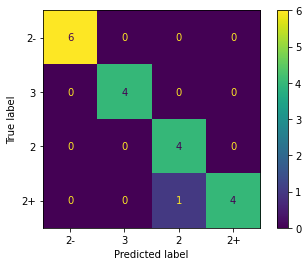

In [19]:
#Criando a matriz de confusão do melhor modelo
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_model, best_X_test, best_y_test, display_labels=["2-", "3", "2", "2+"])

In [21]:
# Access the best set of parameters of best model tunning
best_params = best_model.best_params_
print('Melhores parâmetros', best_params)
# Stores the optimum model in best_pipe
best_pipe = best_model.best_estimator_
print('Melhor pipeline', best_pipe)

Melhores parâmetros {'classifier': KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1), 'classifier__leaf_size': 1, 'classifier__n_neighbors': 1, 'classifier__p': 1, 'scaler': MinMaxScaler(), 'selector': VarianceThreshold()}
Melhor pipeline Pipeline(steps=[('scaler', MinMaxScaler()), ('selector', VarianceThreshold()),
                ('classifier',
                 KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1))])


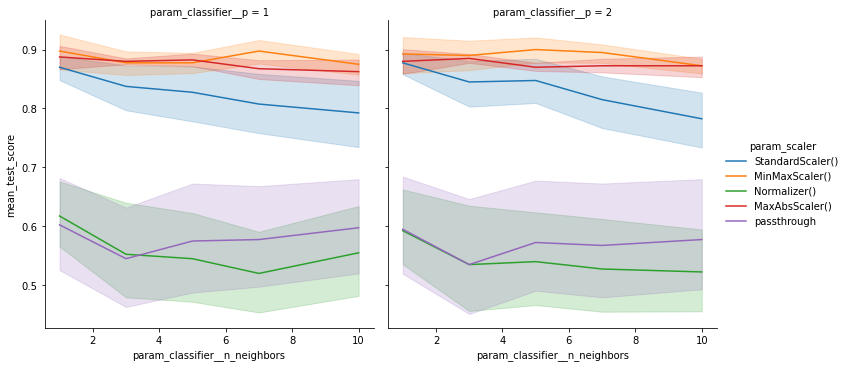

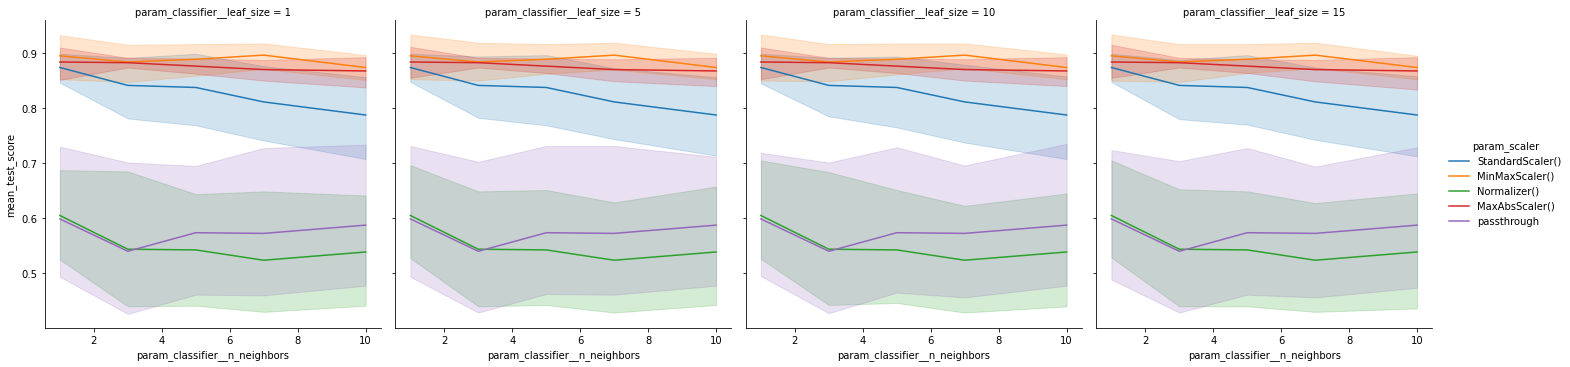

In [22]:
#print('Resultados das colunas', result_df.columns)
result_df = dataset.from_dict(best_model.cv_results_, orient='columns')

sns.relplot(data=result_df, kind='line', 
            x='param_classifier__n_neighbors', 
            y='mean_test_score', 
            hue='param_scaler',
            col='param_classifier__p')
plt.show()

sns.relplot(data=result_df,
            kind='line',
            x='param_classifier__n_neighbors',
            y='mean_test_score',
            hue='param_scaler',
            col='param_classifier__leaf_size')
plt.show()

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.10800
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000


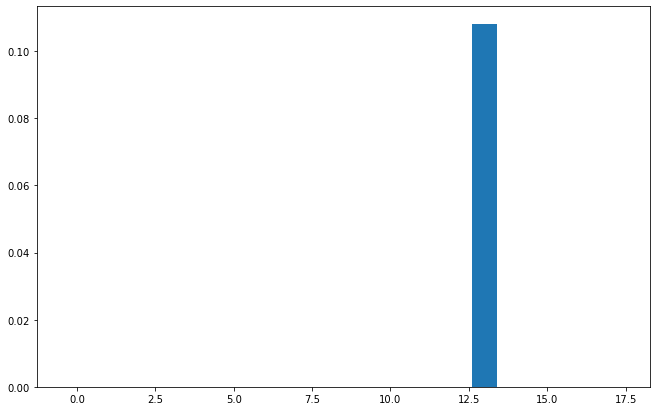

In [44]:
#FEATURE IMPORTANCE
# perform permutation importance
from sklearn.inspection import permutation_importance

results = permutation_importance(best_model, best_X_train, best_y_train, scoring = 'accuracy', random_state=0)
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: medianR, Score: 0.00000
Feature: medianG, Score: 0.00000
Feature: medianB, Score: 0.00000
Feature: histR, Score: 0.00000
Feature: histG, Score: 0.00000
Feature: histB, Score: 0.00000
Feature: R, Score: 0.00000
Feature: G, Score: 0.00000
Feature: B, Score: 0.00000
Feature: saturationHSV, Score: 0.00000
Feature: hueHSV, Score: 0.00000
Feature: valueHSV, Score: 0.00000
Feature: saturationHSI, Score: 0.00000
Feature: hueHSI, Score: 0.11000
Feature: intensityHSI, Score: 0.00000
Feature: lLab, Score: 0.00000
Feature: aLab, Score: 0.00000
Feature: bLab, Score: 0.00000


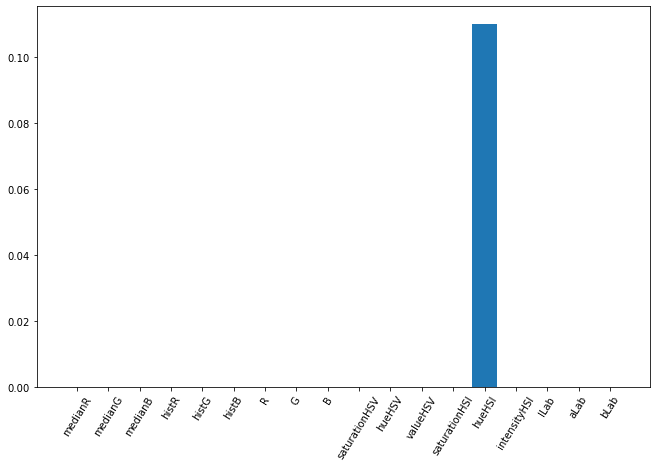

In [28]:
#FEATURE IMPORTANCE
for i,v in enumerate(importance):
    if i == 0:
        print('Feature: medianR, Score: %.5f' % (v))
    if i == 1:
        print('Feature: medianG, Score: %.5f' % (v))
    if i == 2:
        print('Feature: medianB, Score: %.5f' % (v))
    if i == 3:
        print('Feature: histR, Score: %.5f' % (v))
    if i == 4:
        print('Feature: histG, Score: %.5f' % (v))
    if i == 5:
        print('Feature: histB, Score: %.5f' % (v))
    if i == 6:
        print('Feature: R, Score: %.5f' % (v))
    if i == 7:
        print('Feature: G, Score: %.5f' % (v))
    if i == 8:
        print('Feature: B, Score: %.5f' % (v))
    if i == 9:
        print('Feature: saturationHSV, Score: %.5f' % (v))
    if i == 10:
        print('Feature: hueHSV, Score: %.5f' % (v))
    if i == 11:
        print('Feature: valueHSV, Score: %.5f' % (v))
    if i == 12:
        print('Feature: saturationHSI, Score: %.5f' % (v))
    if i == 13:
        print('Feature: hueHSI, Score: %.5f' % (v))
    if i == 14:
        print('Feature: intensityHSI, Score: %.5f' % (v))
    if i == 15:
        print('Feature: lLab, Score: %.5f' % (v))
    if i == 16:
        print('Feature: aLab, Score: %.5f' % (v))
    if i == 17:
        print('Feature: bLab, Score: %.5f' % (v))
        
# plot feature importance
import matplotlib.pyplot as plt
list_features = ["medianR", "medianG", "medianB", "histR", "histG", "histB", "R", "G", "B", "saturationHSV", "hueHSV", 
                 "valueHSV", "saturationHSI", "hueHSI", "intensityHSI", "lLab", "aLab", "bLab"]
plt.rcParams['figure.figsize'] = (11,7)
plt.xticks(rotation=58)
plt.bar([x for x in list_features], importance)
plt.show()